# Customer Churn Exploratory Data Analysis and Modeling

## Project Overview
This project analyzes churn behavior in a subscription-based business using Python. 
Our goal is to understand the drivers of customer attrition and predict churn using machine learning models.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os 
print(os.getcwd())

/Users/smarr/Documents/Data Sets/Churn Analysis


### Business Context and Assumptions

Assumptions are made for the following columns due to the dataset not providing explicit unit definitions:
- Payment Delay (in Days)
- Last Interaction (in Days)
- Tenure
  (in Months)

#### Importing and describing the data 

In [3]:
train_df = pd.read_csv('customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('customer_churn_dataset-testing-master.csv')

In [4]:
## Checking for Null Values
train_df.isnull().sum()
test_df.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [5]:
## Seeing basic statistics on each column
train_df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [6]:
## Make-up of Churn column
train_df['Churn'].value_counts(normalize=True)*100
test_df['Churn'].value_counts(normalize=True)*100

Churn
0    52.631497
1    47.368503
Name: proportion, dtype: float64

- Essential to check balance of churn values, some analyses are skewed so far a specific way that it kills modeling

#### Cleaning the Data

In [7]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
## Fixing data types for columns cast to inconvenient data types
## Cast as string for identifier column
train_df['CustomerID'] = train_df['CustomerID'].astype(int).astype(str)
## For Binary Classification
train_df['Churn'] = train_df['Churn'].astype(int)

test_df['CustomerID'] = test_df['CustomerID'].astype(int).astype(str)
test_df['Churn'] = test_df['Churn'].astype(int)

In [9]:
## Take a look at the first few columns of the data
train_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1
1,3,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1
2,4,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1
3,5,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1
4,6,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1


## EDA

### Churn by Subscription type

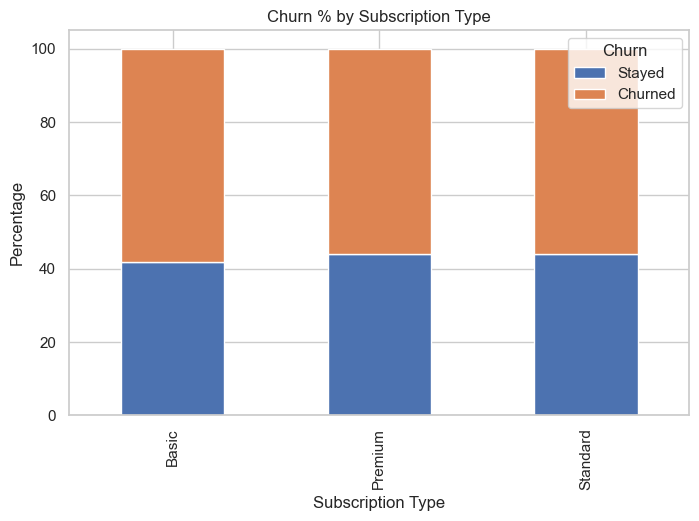

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

churn_by_subscription = pd.crosstab(train_df['Subscription Type'], train_df['Churn'], normalize='index') * 100
churn_by_subscription.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Churn % by Subscription Type")
plt.ylabel("Percentage")
plt.legend(['Stayed', 'Churned'], title="Churn")
plt.savefig('assets/images/ChurnBySubscriptionType.png', dpi=300, bbox_inches='tight')
plt.show()

- Premium and Standard have slightly lower attrition rates compared to basic subscription users 

### Churn by Contract Length

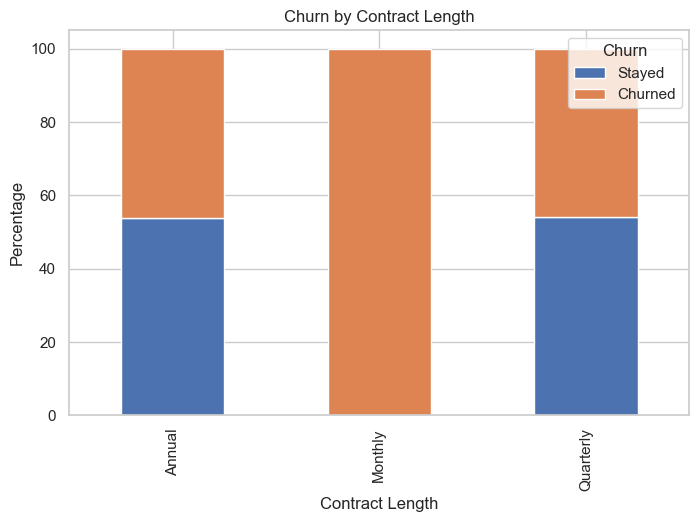

In [82]:
churn_by_contract = pd.crosstab(train_df['Contract Length'], train_df['Churn'], normalize='index')*100
churn_by_contract.plot(kind='bar',stacked='true',figsize=(8,5))
plt.title("Churn by Contract Length")
plt.ylabel("Percentage")
plt.xlabel("Contract Length")
plt.legend(["Stayed", "Churned"],title="Churn")
plt.savefig('assets/images/ChurnByContractLength.png', dpi=300, bbox_inches='tight')
plt.show()

- The monthly subscription attrition data is statistically impossible. We'll be creating a binary column that identifies entries with monthly contract lengths to exclude them in the ensuing analysis if it contributes to skewed analysis. However, for the sake of documentation, I will leave the skewed data.
- Annual and Quarterly attrition rates are about identical.

In [12]:
## Creating the binary Monthly column to filter for monthly contracts
train_df['Is_Monthly_Contract'] = train_df['Contract Length'] == 'Monthly'
test_df ['Is_Monthly_Contract'] = test_df['Contract Length'] == 'Monthly'

### Tenure by Churn

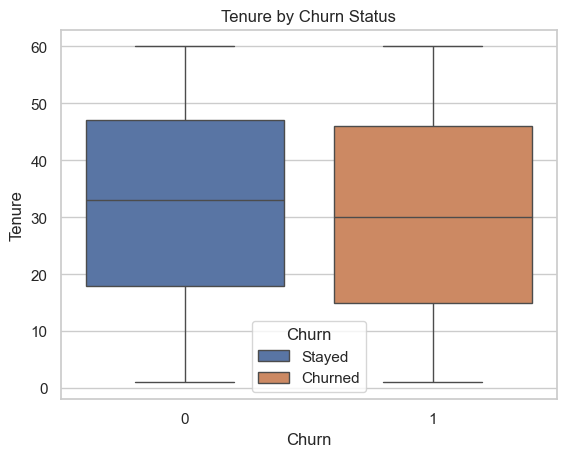

In [83]:
sns.boxplot(data=train_df,x='Churn',y='Tenure', hue='Churn')
plt.title("Tenure by Churn Status")
plt.legend(title='Churn', labels=['Stayed', 'Churned'])
plt.savefig('assets/images/TenureBoxplot.png', dpi=300, bbox_inches='tight')
plt.show()

- Customers who churn tend to have significantly lower tenures than customers who do not

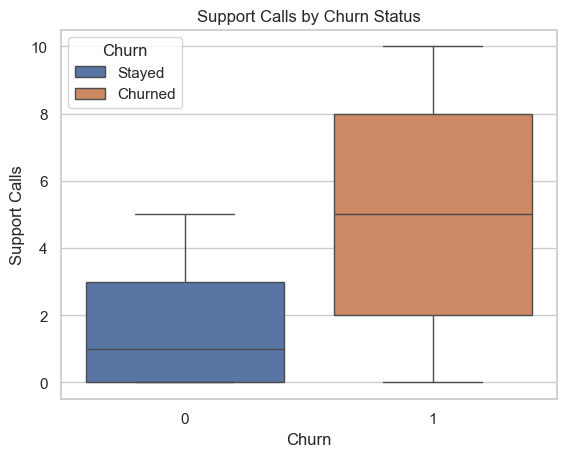

In [84]:
sns.boxplot(data=train_df, x='Churn',y='Support Calls', hue='Churn')
plt.legend(title='Churn', labels=['Stayed', 'Churned'])
plt.title("Support Calls by Churn Status")
plt.savefig('assets/images/SupportCallsBoxplot.png', dpi=300, bbox_inches='tight')
plt.show()

- Clear distinction in responses presented by this box plot. Customers who stay have significantly less support calls than those who do. 

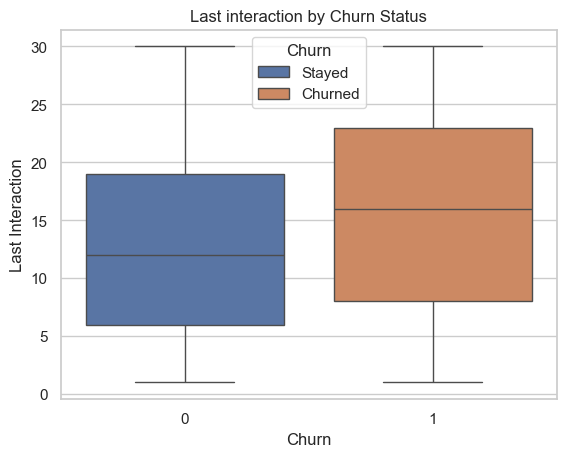

In [85]:
sns.boxplot(data=train_df, x='Churn', y='Last Interaction', hue='Churn')
plt.title("Last interaction by Churn Status")
plt.legend(title='Churn', labels=['Stayed', 'Churned'])
plt.savefig('assets/images/LastInteractionBoxplot.png', dpi=300, bbox_inches='tight')
plt.show()

- Customers who stay interact with the platform much more recently than customers who churn

### Wrapping up insights 
- Churn is higher for basic plans
- Lower tenure, higher support calls, and longer inactivity periods are correlated with churn

## Modeling

In [16]:
## Creating a model-ready dataframe that doesn't contain the faulty 'Monthly' Subscription data
df_model = train_df[train_df['Is_Monthly_Contract'] == False].copy()
df_model.drop('Is_Monthly_Contract',axis=1,inplace=True)

## replicating for our test data frame
test_dfFinal = test_df[test_df['Is_Monthly_Contract'] == False].copy()
test_dfFinal.drop('Is_Monthly_Contract',axis=1,inplace=True)
test_dfFinal.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0
6,7,47,Female,37,15,9,28,Basic,Quarterly,574,14,1
9,10,65,Male,8,4,2,23,Basic,Annual,995,10,0


### Standard Scaler and label encoder (for categorical variables)
- Necessary for Logistic Regression and other ML techniques where standardized features are assumed

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
# Label Encoding Categorical Variables, like Gender, Subscription Type, and Contract length.
le_gender=LabelEncoder()
le_subsc=LabelEncoder()
le_Cont=LabelEncoder()

#fit_transform will compute the mean and std from the data and apply scaling
df_model['Gender']=le_gender.fit_transform(df_model['Gender'])
test_dfFinal['Gender']=le_gender.fit_transform(test_dfFinal['Gender'])
df_model['Subscription Type']=le_subsc.fit_transform(df_model['Subscription Type'])
test_dfFinal['Subscription Type']=le_subsc.fit_transform(test_dfFinal['Subscription Type'])
df_model['Contract Length'] = le_Cont.fit_transform(df_model['Contract Length'])
test_dfFinal['Contract Length'] = le_Cont.fit_transform(test_dfFinal['Contract Length'])

In [18]:
## Separating features from target, dropping Churn from features
X_train = df_model.drop(columns=['CustomerID','Churn'])
X_test = test_dfFinal.drop(columns=['CustomerID','Churn'])

## Setting target variables
Y_train = df_model['Churn']
y_test = test_dfFinal['Churn'].astype(int)

In [19]:
type(y_test)

pandas.core.series.Series

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, Y_train)

LogisticRegression(max_iter=1000)

- Checking accuracy of the logistic regresion in below accuracy assessment

In [22]:
log_model.score(X_test_scaled, y_test)

0.711817062778146

- Our Logistic Regression predicted the churn rate accurately over 71% of the time

In [23]:
## Predicts 0 or 1 value for every row in X_test_scaled data set 
Y_pred = log_model.predict(X_test_scaled)

In [24]:
Y_proba = log_model.predict_proba(X_test_scaled)

In [25]:
## Evaluating with classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72     23172
           1       0.65      0.77      0.71     19072

    accuracy                           0.71     42244
   macro avg       0.72      0.72      0.71     42244
weighted avg       0.72      0.71      0.71     42244



#### Class-by-Class Breakdown
- Of all customers predicted to stay, 78% actually stayed
- Model correctly identified 67% of actual stayers

- Of all customers predicted to churn, 65% actually churned
- Caught 77% of all real churners — strong recall
-  Good overall balance between false positives and false negatives

#### Overall Performance
- Accuracy: 71%
- Macro avg: 0.72 precision, 0.72 recall — balanced model
  

## Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_scaled, Y_train)

RandomForestClassifier()

In [27]:
rf_model.score(X_test_scaled, y_test)

0.5450241454407726

- Our Random Forest Classifier predicted the churn rate accurately over 55% of the time - similar to the odds provided by chance

In [28]:
Y_pred_RF=rf_model.predict(X_test_scaled)

In [29]:
print(classification_report(y_test, Y_pred_RF))

              precision    recall  f1-score   support

           0       0.83      0.22      0.34     23172
           1       0.50      0.95      0.65     19072

    accuracy                           0.55     42244
   macro avg       0.66      0.58      0.50     42244
weighted avg       0.68      0.55      0.48     42244



### Class-by-Class Breakdown
- Strong recall but weak precision on Churners; 95% recall, 50% precision, meaning the model flags churners even when they're not
- Very poor recall on non-churners, suggesting the model is sensitive to predict churners

### Overall Performance
- Only slightly better than randomly guessing, unusable without tuning
- Model misclassifies the majority of loyal customers, which could waste retention resources and damage relationships if acted on without nuance

## Plotting ROC Curve to compare models
#### (Receiver Operating Characteristic)

- Used to evaluate the performance of binary classifier models such as our logistic regression and random forest classifier
  

#### Calculations
- Calculating probability predictions, true and false positive rate (for the ROC curve) and the area under the curve

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probability Predictions
y_prob_log = log_model.predict_proba(X_test_scaled)[:,1]
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:,1]

# Computing False and True Positive Rates
fpr_log, tpr_log,_=roc_curve(y_test,y_prob_log)
fpr_rf, tpr_rf,_=roc_curve(y_test, y_prob_rf)

#Compute area under curve
auc_log = roc_auc_score(y_test,y_prob_log)
auc_rf = roc_auc_score(y_test,y_prob_rf)

#### Visualization and insight

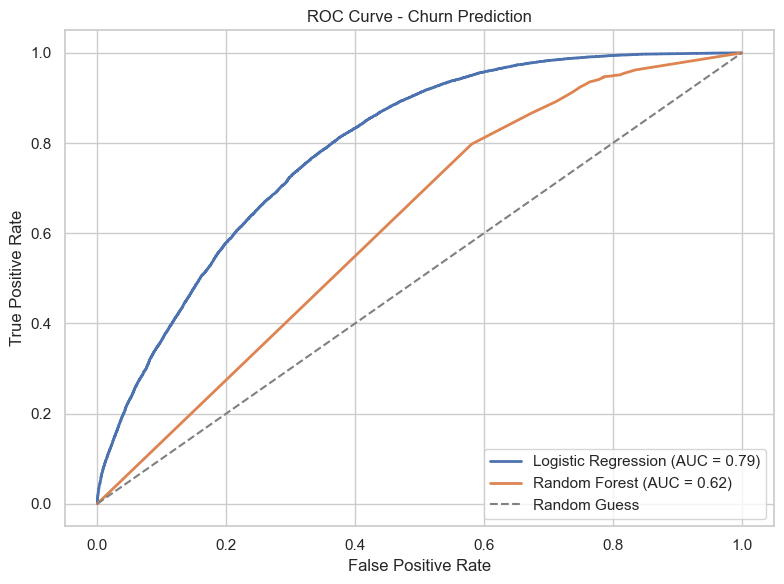

Logistic Regression AUC is 0.7900278538731944
Random Forest Classifier AUC is 0.6193610945144539


In [89]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")

plt.title("ROC Curve - Churn Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('assets/images/ROC_LR_RF_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Logistic Regression AUC is", auc_log)
print("Random Forest Classifier AUC is", auc_rf)

##### Our AUC estimates suggest our Logistic Regression is a far more suitable model to predict the churn rate for our subscription product
- Despite its complexity, our Random Forest Classifier model exhibited signs of over-fitting - achieving high training accuracy but a lower AUC on test data; More commplex isn't necssarily better
- This test highlights the importance of evaluating model generalization, not just fit

##### Our ROC Curve verifies the reliability of our logistic regression in that it produces a higher true positive rate and lower false positive rate than our Random foreset classifier 
- Logistic Regression curve sits much higher than our RF Classifier, which hugs the diagonal line denoting chance estimate
- Said differently, our Logistic Regression consistently outperforms Random Forest in distinguishing churners from loyal customers

- Overall, Given its high AUC and non-complex structure, the logistic regression serves as a reliable foundaction for churn-risk scoring systems,flagging at-risk customers early for intervention.

### Calculating and plotting Logistic Regression Coefficients

In [54]:
feature_names = X_train.columns
coefficients = log_model.coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'coefficients': coefficients})

coef_df['Abs_coefficients'] = coef_df['coefficients'].abs()
coef_df.sort_values(by='Abs_coefficients',ascending=False, inplace=True)

coef_df.drop(columns='Abs_coefficients', inplace=True)

coef_df

,Feature,coefficients
4,Support Calls,2.206015
8,Total Spend,-1.402743
5,Payment Delay,0.898523
1,Gender,-0.569675
9,Last Interaction,0.522829
0,Age,0.427030
2,Tenure,-0.133455
3,Usage Frequency,-0.127561
6,Subscription Type,-0.048833
7,Contract Length,-0.002963


Our Logistic Regression model reveals that churn is mostly driven by elevated support calls, delayed payments, and inactivity. Meanwhile, customers who spend more, use the platform frequently, or have longer tenure are significantly less likely to churn. These insights can guide retention campaigns that prioritizing high-risk users and reinforce loyalty among engaged and high-value customers.

- Support Calls had the highest positive coefficient (+2.21), making it the strongest indicator of churn.

- Payment Delay (+0.90) and Last Interaction (+0.52) were also positively associated with churn, signaling behavioral disengagement or friction.

- Total Spend showed a strong negative coefficient (–1.40), suggesting that higher-value customers are less likely to leave.

- Age (+0.43) had a modest positive effect, while Gender (–0.57) indicated a lower churn likelihood for males (assuming label encoding).

- Tenure and Usage Frequency both had slight negative effects (around –0.13), reinforcing that consistent, long-term engagement helps retain users.

- Subscription Type and Contract Length showed minimal predictive influence in the current model.



### Tuning Random Forest Classifier model
- To achieve more accurate ROC Curve and AUM estimates, we will tune the RF Classifier
- Tuning the model means adjusting the hyperparameters to improve performance
- Tuninng our model will ensure we can ameliorate the negative effects of overfitting and improve generalization
- Overall, we want to help balance the trade-off between recall and precision

-----------
##### To recap the poor performance of our initial model
- Recall was high (0.95), meaning our model was able to catch every churner (true positive)
- Precision was very low (0.50), wrongly flagging many loyal customers as churners (false positives)
- This high recall, low precision combination most typically means that our model was overfit to the churn class and biased towards majority or high-variance features like support calls or payment delay

##### What each parameter can do to achieve a more accurate fit
- max_depth=10 (Stops trees from growing too complex (controls overfitting))
- min_samples_split=20 (Forces nodes to be more statistically meaningful before splitting)
- class_weight='balanced' (Helps the model treat churners and stayers fairly, especially in imbalanced data)
- min_samples_leaf=5 (Prevents tiny leaf nodes from forming on noise)




In [57]:
rf_model_tuned = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=20,class_weight='balanced',random_state=42)

The above tuned parameters values will: 
- Encourage generalization
- Reduce the “overconfident churn” behavior
- Help the model respect both classes (stay + churn)

In [59]:
rf_model_tuned.fit(X_train_scaled, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=20, random_state=42)

In [60]:
rf_model_tuned.score(X_test_scaled,y_test)

0.5552031057664993

- 0.5552031057664993 compared to 0.5450241454407726 - a very insignificant change. Lets run the classification report to observe any notable differences

In [64]:
Y_pred_RF_tuned = rf_model_tuned.predict(X_test_scaled)

#Calculating Probability
Y_proba_RF_tuned = rf_model_tuned.predict_proba(X_test_scaled)[:,1]

In [65]:
print(classification_report(y_test, Y_pred_RF_tuned))
print("AUC Score for our tuned random forest is", roc_auc_score(y_test,Y_proba_RF_tuned))

              precision    recall  f1-score   support

           0       0.81      0.25      0.38     23172
           1       0.50      0.93      0.65     19072

    accuracy                           0.56     42244
   macro avg       0.66      0.59      0.52     42244
weighted avg       0.67      0.56      0.50     42244

AUC Score for our tuned random forest is 0.6801006793774191


### AUC breakdown
- We achieve a greater AUC score for our tuned random forest classifier model - 0.6801006793774191 vs 0.6193610945144539.
- We have a better-performing model here - one capable at more accurately distinguishing between positive and negative classes.
-----------
### Classification Report Breakdown
- Minimal deviation from the initial classification report - recall is high but precision is akin to that of guessing.
- Loyal customers often misclassified as churners - an inaccurate insight that could spell disaster for any sales/marketing ploy.
- Overall accuracy is up to 56% from 50% in initial report, a small but noticeable improvement.

### Visualizing tuned RF Model ROC curve

In [66]:
fpr_rft, tpr_rft,_= roc_curve(y_test, Y_proba_RF_tuned)
auc_score_rft = roc_auc_score(y_test, Y_proba_RF_tuned)

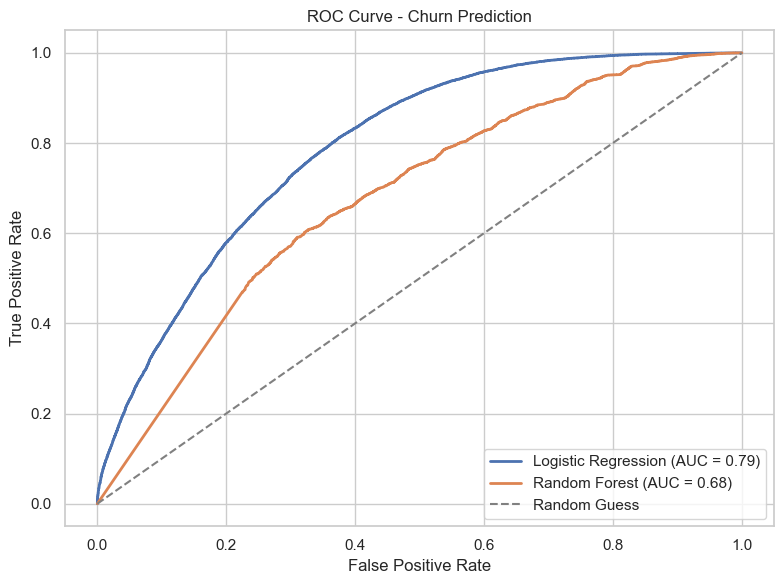

Random Forest Classifier AUC is 0.6193610945144539


In [92]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2)
plt.plot(fpr_rft, tpr_rft, label=f"Random Forest (AUC = {auc_score_rft:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")

plt.title("ROC Curve - Churn Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('assets/images/ROC_LR_RFT_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Random Forest Classifier AUC is", auc_rf)

### ROC curve breakdown
- ROC curve for our tuned classifier model, visually, is slightly different than our initial model

## Feature Importance plots (for all models)
- Plot feature importance by model to determine the relative importance of each feature in predicting churn

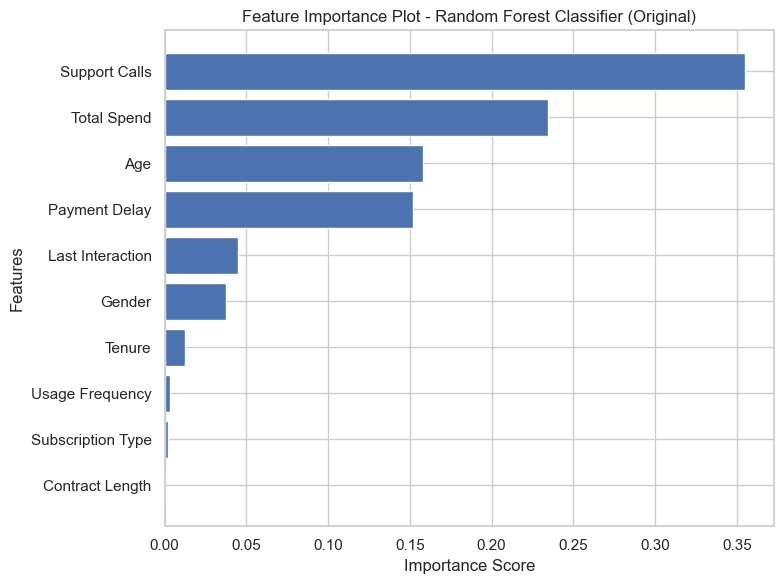

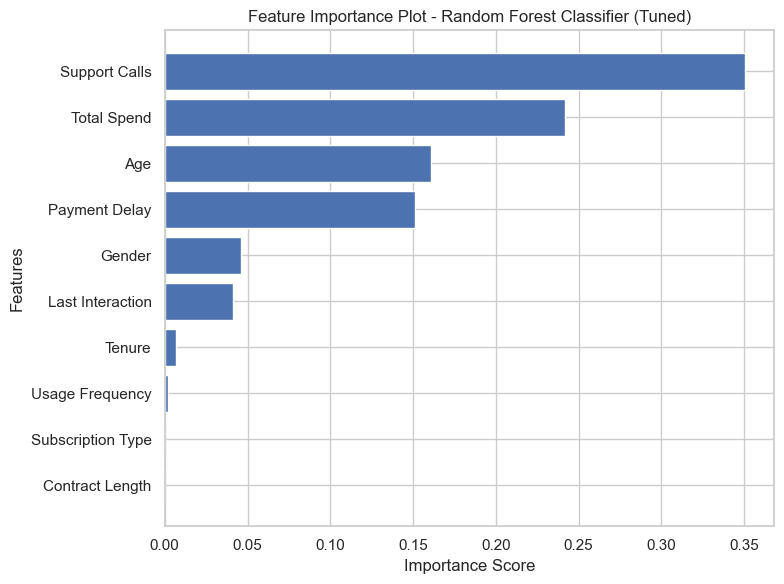

In [72]:
def plot_rf_feature_importance(model, feature_names, title):
    importance_df=pd.DataFrame({'Features': feature_names,
                                'Importance':model.feature_importances_}).sort_values(by='Importance',ascending=True)
    plt.figure(figsize=(8,6))
    plt.barh(importance_df['Features'],importance_df['Importance'])
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('assets/images/FeatureImportance_RF_.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_rf_feature_importance(rf_model, feature_names, 'Feature Importance Plot - Random Forest Classifier (Original)')
plot_rf_feature_importance(rf_model_tuned, feature_names, 'Feature Importance Plot - Random Forest Classifier (Tuned)')

#### Feature Importance Plot - Random Forest Classifier original vs Tuned side-by-side Comparison
- All features, except for last interaction, maintain same ranking in importance across both models, with Support Calls and Total Spend being the most important determinants of churn.
- the tuned model has slightly lower scores for support call, tenure and last interaction, and higher scores for total spend, age, and gender. This insight reflects the shifts in "thinking" that the model exhibits in response to the altered parameters
- Its important to note the significant increase in the importance of Gender in churn - it could be worth exploring why the model pinned value on that feature

### Logistic Regression Coefficient Plot

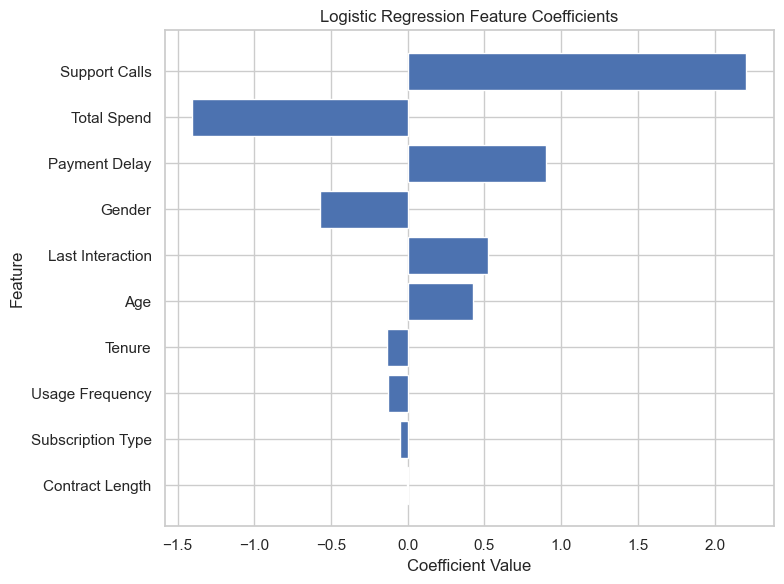

In [87]:
def plot_logistic_regression(model, feature_names, title):
    coef_df = pd.DataFrame({ 'Features': feature_names,
                            'Coefficient':model.coef_[0]})
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df.sort_values(by='Abs_Coefficient', ascending = True, inplace=True)

    
    plt.figure(figsize=(8, 6))
    plt.barh(coef_df['Features'], coef_df['Coefficient'])
    plt.title(title)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('assets/images/LogisticRegressionCoefficients.png', dpi=300, bbox_inches='tight')

    plt.show()

plot_logistic_regression(log_model, X_train.columns, 'Logistic Regression Feature Coefficients')
        

#### Logistic Regression Feature Coefficients breakdown
- This illustration visualizes the table from our logistic regression coefficients
- Support Calls has a highly positive coefficient, denoting its positive influence in whether a customer churns or not. Said differently, more support calls correlate to higher churn incidence.
- On the other hand, Total spend has a highly negative coefficient, denoting its negative influence in whether a customer churns or not. Said differently, higher total spend correlates to lower churn incidence.
--------
- In comparison to the feature importance of our random forest classifier model, our Logistic Regression coefficients visualization incorporates direction in addition to the relative importance of each feature, providing more insight into the direct influence of each feature

## Conclusion
### To recap
#### Data Prep
- Cleaned and joined training + test datasets
- Removed monthly contracts due to labeling anomaly (all marked as churned)
- Encoded categorical features and applied StandardScaler to numeric features
#### EDA Findings
- Churn was more common among Basic subscribers, Quarterly contracts, and those with low tenure
- Boxplots showed higher churn among users with fewer months of tenure and more support interactions
- Churners had longer payment delays and fewer recent interactions
#### Models Built
Logistic Regression
- AUC: 0.79
- Balanced performance: Churn recall ~77%, stay recall ~67%
- Most interpretable model
  
Random Forest (Default)
- AUC: 0.62
- High churn recall (95%) but poor loyalty recall (22%)
- Overfit to churn class
  
Random Forest (Tuned)
- Parameters: max_depth=10, min_samples_split=20, class_weight='balanced'
- AUC: 0.68
- Still high churn recall (93%) but low stay recall (25%)

#### Key insights from Feature Importance & Coefficient Visualizations
- In both models, Support Calls stands out as the most influential feature. This confirms its strong predictive power in identifying dissatisfied customers.
- Total Spend consistently ranks high and appears as a strong retention signal — customers who spend more are significantly less likely to churn.
- Payment Delay and Last Interaction showed strong positive influence in the Logistic model and moderate-to-high importance in Random Forest, highlighting customer behavior patterns linked to churn risk.
- While Random Forest treats features more as decision-split contributors, Logistic Regression allows us to clearly see the directional impact of each input — such as how longer tenure, higher usage, and male gender are associated with lower churn likelihood.
- The consistency across both models in key variables (Support Calls, Total Spend, Payment Delay) increases confidence in their role as actionable business levers.
  
#### Key insights from the models
- Support Calls was the top feature in both models — high support volume strongly predicts churn
- Total Spend had a strong negative impact on churn — high spenders were more likely to stay
- Payment Delay and Last Interaction also indicated risk of churn
- Logistic Regression emerged as the most reliable, generalizable, and interpretable model
  
#### Business insights
- Logistic Regression is the best model for this business case due to its:
    - Higher AUC
    - Balanced class performance
    - Interpretability for stakeholders
- Random Forest models overfit to churners, which may be useful in aggressive retention campaigns but lack balance